In [69]:
pip install pymoo

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/394.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/394.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/394.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/394.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/394.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/394.5 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/394.5 kB 140.3 kB/s eta 0:00:03
   ------ -------------------------------- 61.4/394.5 kB 218.8 kB/s eta 0:00:02
   ------ -------------------------------- 61.4/394.5 kB 218.8 kB/s eta 0:00:02
   ------- ------------------------------- 71.7/394.5 kB 187.3 kB/s eta 0:00:02
   ------- ------------------------------- 71.7/394.5 kB 187.3 kB/s eta 0:00:02
   ------- ------------------------------- 71.7/394.5 kB 187.3 kB/s 

In [61]:
import numpy as np

def DTLZ1(x, n_obj=3, k=5):
    n_var = len(x)
    g = sum((x[k-1:] - 0.5)**2)
    
    objectives = [0.5 * (1 + g)] * n_obj
    for i in range(n_obj):
        for j in range(n_obj - 1 - i):
            objectives[i] *= x[j]
        if i != 0:
            objectives[i] *= (1 - x[n_obj - 1 - i])
    return objectives

problem = {
"FitnessFunction": DTLZ1,
"DV": 10, 
"LB": np.zeros(10), 
"UB": np.ones(10), 
}

params = {
"Gmax": 1000, 
"PS": 100 
}

In [62]:
def PVS(problem, params):

    FitnessFunction = problem["FitnessFunction"]
    DV = problem["DV"]
    LB = problem["LB"]
    UB = problem["UB"]
    VarSize = (1,10)


    Gmax = params["Gmax"]
    PS = params["PS"]

    # Initialization
    empty_vehicle = {"Position": None, "Fitness": None, "CrowdingDistance": None}
    FE = 0
    g = 1


    pop = [empty_vehicle.copy() for _ in range(PS)]

    for i in range(PS):

        pop[i]["Position"] = np.random.uniform(LB, UB, VarSize)[0]
        pop[i]["Fitness"] = FitnessFunction(pop[i]["Position"])
        FE += 1
    while g <= Gmax:
        FitnessFunction = problem["FitnessFunction"]
        for i in range(PS):
            pop[i]["CrowdingDistance"] = 0

        for g in range(1, Gmax + 1):
            for i in range(PS):
                r = np.zeros(3, dtype=int)
                r[0] = i
                r1, r2, r3 = pop[r[0]], pop[r[1]], pop[r[2]]
                r[1] = r[0]
                while r[1] == r[0]:
                    r[1] = np.random.randint(0, PS)
                r[2] = r[0]
                while r[2] == r[0] or r[2] == r[1]:
                    r[2] = np.random.randint(0, PS)

                D = np.array([r[k] / PS for k in range(3)])
                V = np.random.rand(3) * (1 - D)
            
                y = np.linalg.norm(np.array(r2["Position"]) - np.array(r3["Position"]))
                x = np.linalg.norm(np.array(r2["Position"]) - np.array(r1["Position"]))
                x1 = V[2] * x / (V[0] - V[2])
                y1 = V[1] * x / (V[0] - V[1])

                if V[0] > V[2]:
                    if (y - y1) > x1:
                        Vco = V[0] / (V[0] - V[2])
                        X_new =np.array(r1["Position"]) + Vco * np.random.rand(*VarSize)*((np.array(r1["Position"]) - np.array(r3["Position"])))
                    else:
                        X_new = np.array(r1["Position"]) + (np.random.rand(*VarSize))*((np.array(r1["Position"]) - np.array(r2["Position"])) )
                else:
                    X_new =np.array(r1["Position"]) + np.random.rand(*VarSize)*((np.array(r3["Position"]) - np.array(r1["Position"])))

                X_new = np.maximum(X_new, LB)
                X_new = np.minimum(X_new, UB)

                if np.linalg.norm(X_new - np.array(r1["Position"])) < 0.01: 
               
                    F_new = FitnessFunction(X_new[0])

                    pop[r[0]]["Fitness"] = F_new


            pop = NonDominatedSorting(pop)


            pop = calculate_crowding_distance(pop)


            pop = sorted(pop, key=lambda x: (x["Rank"], x["CrowdingDistance"]))


            pop = pop[:PS]

            BestFitnessInGeneration = [ind["Fitness"] for ind in pop]

            g += 10


        pareto_front = [ind["Position"] for ind in pop if ind["Rank"] == 1]

        out = {"population": pop, "pareto_front": pareto_front}

    return out



In [63]:
def NonDominatedSorting(pop):
    n = len(pop)
    for i in range(n):
        pop[i]["DominationCount"] = 0
        pop[i]["DominatedSolutions"] = []
        
    for i in range(n):
        for j in range(n):
            if i != j:
                if Dominates(pop[i]["Fitness"], pop[j]["Fitness"]):
                    pop[i]["DominatedSolutions"].append(j)
                elif Dominates(pop[j]["Fitness"], pop[i]["Fitness"]):
                    pop[i]["DominationCount"] += 1

    fronts = []
    front = []
    for ind in pop:
        if ind["DominationCount"] == 0:
            ind["Rank"] = 1
            front.append(ind)
    fronts.append(front)

    i = 0
    while len(fronts[i]) > 0:
        Q = []
        for ind in fronts[i]:
            for j in ind["DominatedSolutions"]:
                pop[j]["DominationCount"] -= 1
                if pop[j]["DominationCount"] == 0:
                    pop[j]["Rank"] = i + 2
                    Q.append(pop[j])
        i += 1
        fronts.append(Q)
    return pop

def Dominates(fitness1, fitness2):
    return all(f1 <= f2 for f1, f2 in zip(fitness1, fitness2)) and any(f1 < f2 for f1, f2 in zip(fitness1, fitness2))


In [64]:
import numpy as np

def calculate_crowding_distance(population,problem=problem, Gmax=100, VarSize=(1,10), LB=np.zeros(10), UB=np.ones(10), DV=3):
    population = sorted(population, key=lambda x: np.sum(x["Fitness"]))
    for i in range(1, len(population) - 1):
        population[i]["CrowdingDistance"] += np.sum((np.array(population[i+1]["Fitness"]) - np.array(population[i-1]["Fitness"])) \
                                                      / (np.array(population[-1]["Fitness"]) - np.array(population[0]["Fitness"])))

    return population

In [65]:
result = PVS(problem, params)
p = result["population"]
pa = result["pareto_front"]

In [66]:
fit=[]

for ind in range(len(p)):
    k=p[ind]["Fitness"]
    fit.append(k)
fit=np.array(fit)

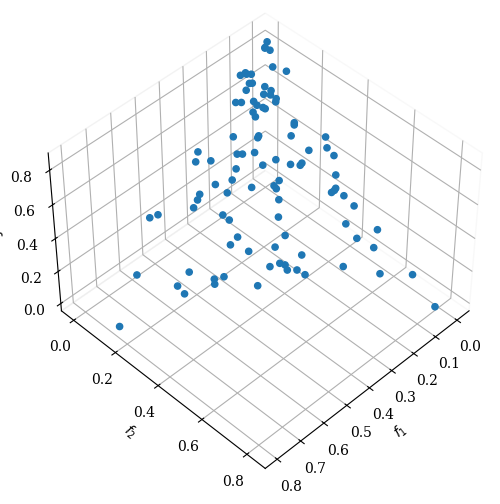

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.visualization.scatter import Scatter
Scatter(angle=(45,45)).add(fit).show()

In [71]:
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

ref_pf = get_problem("dtlz1").pareto_front(ref_dirs)


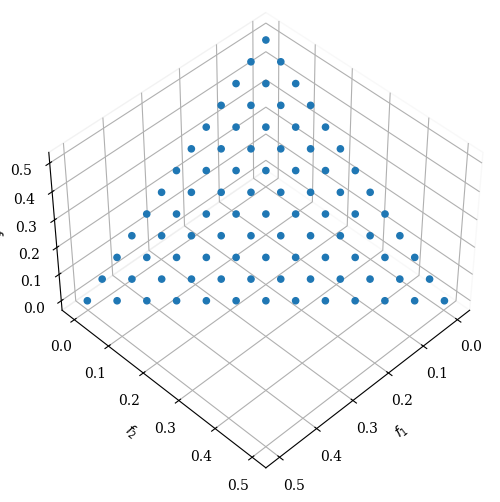

In [74]:
Scatter(angle=(45,45)).add(ref_pf).show()

In [72]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

if len(ref_pf) != len(fit):
    if len(ref_pf) > len(fit):
        ref_pf = ref_pf[:len(fit)]
    else:
        fit = fit[:len(ref_pf)]

mse_list = []
mae_list = []
rmse_list = []
for i in range(fit.shape[1]):  
    mse = mean_squared_error(ref_pf[:, i], fit[:, i])
    mae = mean_absolute_error(ref_pf[:, i], fit[:, i])
    rmse = np.sqrt(mse)  
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)

# Calculate average MSE, MAE, and RMSE across objectives
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_rmse = np.mean(rmse_list)

print("Average MSE:", avg_mse)
print("Average MAE:", avg_mae)
print("Average RMSE:", avg_rmse)


Average MSE: 0.06836899481720811
Average MAE: 0.20244957662477817
Average RMSE: 0.2553438957045833


In [75]:
from pymoo.indicators.gd import GD

ind = GD(fit)
print("Generational Distance", ind(ref_pf))

Generational Distance 0.09947396342625855
